<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The (nodal) Discontinuous Galerkin Method for the linear advection equation</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* Stephanie Wollherr ([@swollherr](https://github.com/swollherr))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
---

The following notebook presents a 1D discontinuous Galerkin code for the advection equation using two different approaches for the integration in time.

---

### The discretization of the advection equation

To keep things simple we want to solve the linear advection equation as a (scalar) hyperbolic equation:

$$ \partial_t u + \mu \ \partial_x u=0$$
1. We first derive the **weak form** of the equation by multiplying it by an arbitrary test function and integration by parts.

2. As in the Spectral Element Method, we approximate our unknown variable u(x,t) by a sum over space-dependent basis functions $\psi_i$ weighted by time-dependent coefficients $u_i(t)$

$$ u(x,t) \ \approx \ \overline{u}(x,t) \ = \ \sum_{i=1}^{n} u_i(t) \
\psi_i(x) $$

As interpolating functions we choose the **Lagrange polynomials** and use
$\xi$ as the space variable representing our elemental domain:

$$ \psi_i \ \rightarrow \ \ell_i^{(N)} (\xi) \ := \ \prod_{k = 1, \ k
\neq i}^{N+1} \frac{\xi - \xi_k}{\xi_i-\xi_k}, \qquad   i = 1, 2, \dotsc
, N + 1  $$

Finally we get the (local) semi-discrete scheme for the k-th element that we derived in the lecture:

$$  M^k \cdot \partial_{t} u_h^k(t) -  \mu \ (S^k)^T \cdot u_h^k(t)= -[(\mu \ u)^*(t) \ l_j^k(x)]_{x^{k}_l}^{x^{k}_r}$$

<div style="clear:both"></div> 

---

We will use the following ingredients that we already discussed in previous exercises during the spectral element method:
* Interpolating polynomials (**the Lagrange polynomials**, calculated in the routine 'lagrange.py'  )
* Numerical integration (**the Gauss-Lobatto-Legendre approach**, getting the GLL points $\xi_{i}$ and their corresponding weights in the routine 'gll.py')
* How we can calculate the **mass and stiffness matrix** using some nice properties of our basis functions.



## Exercises ##

### 1. Examine the code below ###
Look how the mass and stiffness matrix are calculated and compare them to the elemental system matrices for the spectral element code. What are the differences? <br>
Take a closer look at the stiffness matrix: where is the Jacobian that we use to map our element to the reference element $I=[-1,1]$?  <br>
How is the flux calculated at the boundaries? Try different values for $\alpha \in [0,1]$ and see what happens.
What kind of flux do we get for $\alpha=1$ or $\alpha=0$? <br>
Try different orders of approximations.
Try the Euler and the Runge-Kutta scheme for the time extrapolation. What do you notice?

### 2. Time schemes ###

Formulate the analytical solution to the advection problem and plot it along with the numerical solution each time step you visualize it during extrapolation.
Formulate an error between analytical and numerical result. 
Analyze the solution error as a function of propagation distance for the Euler scheme and the predictor-corrector scheme. <br>
(You find the implementation already in the code using exercice = 2).

### 3. The Courant Criterion ###
Using the sampling code below find numerically the Courant limit (for a fixed time extrapolation to $t_{max}$), keeping all other parameters constant, increasing the global spatial order $N$ of the scheme.<br>
(like in the SEM Code).

### 4. How discontinuous is the discontinuous Galerkin method? ###
Extract the field values at the element boundaries and calculate the relative amount of the field discontinuity. <br>
How do the discontinuities compare with the flux values?
(You find the implementation already in the code using exercice = 4).

<div style="clear:both"></div>

---

### The Code 

In [1]:
# This is a configuration step. Please run it before the simulation code!

# Imports etc
import numpy as np
import matplotlib.pyplot as plt

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

# import of DG modules from same directory as the notebook
# we use the same functions that we already know from the spectral element method
from gll import gll
from lagrange import lagrange
from lagrange1st import lagrange1st
from legendre import legendre


In [2]:
# ---------------------------------------------------------------
#
# Discontinous galerkin method for the
# 1D advection equation using an upwind flux
#

# ---------------------------------------------------------------
# Initialization of setup
# ---------------------------------------------------------------
nt = 800        # number of time steps   
xmax = 30.      # Length of domain
rho = 1         # Density for homogeneous model, if you change the density, take that into account for a analytical solution!
mu = 20         # Speed of the wave, positive=propagating to the right, negative=propagating to the left 
N = 6           # Order of Lagrange polynomials
ne = 100        # Number of elements


# ----------------------------------------------------------------

# Initialization of GLL points integration weights
[xi, w] = gll(N)  # xi -> N+1 coordinates [-1 1] of GLL points
                  # w integration weights at GLL locations
    
# Space domain
le = xmax / ne  # Length of elements for regular grid points


# Vector with GLL points, same values for boundary points
k = -1
xg = np.zeros((N +1)* ne)
#xg[k] = 0
for i in range(1, ne + 1):
    for j in range(0, N+1):
        k += 1
        xg[k] = (i - 1) * le + .5 * (xi[j] + 1) * le

x=np.reshape(xg,(ne,(N+1))) #Matrix containing all GLL points in every element
x=x.T


# ---------------------------------------------------------------
# Calculation if time step according to Courant criterion

dxmin = min(np.diff(xg[0:N]))
eps = 0.1    # Courant value orig 0.1

dt = eps * dxmin / (np.abs(mu))  # Global time step

#-----------------------------------------------------------------
#---Exercice 3: Find the courant limit, dt fixed and N decreasing
#dt=0.0004 #or some other max. timestep
#eps= dt*(np.abs(mu)/dxmin)
#print(eps)
#----------------------------------------------------------------


J = le / 2  # Mapping - Jacobian, same for every element if the element size is everywhere the same
Ji = 1 / J  # Inverse Jacobian

# Initialization of 1st derivative of Lagrange polynomials used in the stiffness matrix
l1d = lagrange1st(N)  # Array with GLL as columns for each N+1 polynomial


### The system matrices ###
The mass and the stiffness matrix can be precalculated and stored when we transform every element to a reference elemen. <br>
In the 1D case this is simply the transformation to the interval $I=[-1,1]$ with $dx= J \ d\xi$ and hence $J=\frac{dx}{d\xi}$. Additionally we also have to transform a spacial derivative with respect to $x$ into a spacial derivative with respect to $\xi$. <br>
The Lagrange polynomials have some nice properties that we will use to calculate the mass and stiffness matrix.
At the GLL-points $x_j$ it holds:
$$ l_i(x_j) = \delta_{ij}= \begin{cases} 1 \ \text{ if $i=j$} \\ 0 \ \text{ if $i \neq j $} \end{cases} $$
For the numerical integration we use the numerical quadrature, that uses the GLL and their corresponding weights to approximate an integral.


$$ M_{ij}^k=\int_{-1}^1 l_i^k(\xi)  l_j^k(\xi) \ J \ d\xi = \sum_{m=1}^{N_p} w_m \ l_i^k (x_m)  l_j^k(x_m)\ J =\sum_{m=1}^{N_p} w_m \delta_{im}\ \delta_{jm} \ J= \begin{cases} w_i \ J \ \ \text{ if } i=j \\ 0 \ \ \ \ \ \ \ \text{   if } i \neq j\end{cases}$$
 **Note** : We have a diagonal mass matrix!
 
 
 $$ S_{i,j}= \int_{-1}^1 l_i^k(\xi) \cdot \partial _x  l_j^k(\xi) \ d\xi= \sum_{m=1}^{N_p} w_m \ l_i^k(x_m)\cdot \partial_x l_j^k(x_m)= \sum_{m=1}^{N_p} w_m \delta_{im}\cdot \partial_xl_j^k(x_m)= w_i \cdot \partial_x l_j^k(x_i) $$
We already calculated the Lagrange polynomials. They will be used to calculate the first derivatives of the Lagrange polynomials in the function "Lagrange1st". Now we have all the ingredients to calculate the mass and stiffness matrix:

In [3]:
# -----------------------------------------------------------------
# Initialization of system matrices
# -----------------------------------------------------------------


# variables for elemental matrices
Me = np.zeros(N + 1, dtype=float)
Ke = np.zeros([N + 1, N + 1], dtype=float)


# Mass matrix
# Elemental
for i in range(-1, N):
    Me[i + 1] = rho * w[i + 1] * J #only a vector since the matrix is diagonal



# Build inverse matrix
Minv = np.identity(N+1)
for i in range(0, N+1):
    Minv[i,i] = 1. / Me[i]


# ---------------------------------------------------------------
# Stiffness Matrix
# Elemental

for i in range(-1, N):
    for j in range(-1, N):
            Ke[i+1,j+1] = mu * w[j + 1] * l1d[i + 1, j + 1] #corrected indices


# ---------------------------------------------------------------

### The numerical flux

The big difference to the Spectral Element Method is the communication between the element neighbors using a flux term $(\mu \ u)^*$. <br>
For the 1D advection equation we can derive the general formula for a numerical upwind flux
$$ (\mu \ u )^*= \frac{\mu}{2}(u^++u^-) +\frac{|\mu|}{2}(\hat n^+u^++\hat n^-u^-)$$
with $u^-$ as the interior information, 
$u^+$ the exterior information and 
$\hat n$ the corresponding outer pointing normal vectors. <br>
This leads to the update on the right boundary of an element
$$ \frac{\mu}{2}\big(u_h^k(x_r^k)+u_h^{k+1}(x_l^{k+1})\big )+ \frac{|\mu|}{2}\big(u_h^k(x_r^k)-u_h^{k+1}(x_l^{k+1})\big )$$
and on the left boundary of an element
$$\frac{\mu}{2}\big(u_h^k(x_l^k)+u_h^{k-1}(x_r^{k-1}) \big)+ \frac{|\mu|}{2}(-u_h^{k}(x_l^{k}+u_h^{k-1}(x_r^{k-1}))\big)$$

For a positive travel speed $\mu$ (-> $\mu=|\mu|$) the value on the left boundary is the value of the previous element $k-1$ from where the wave is coming from. On the right boundary it's just the value of the actual element $k$ (and vice versa for $\mu$ being negative).
Notice that we only consider the first (left boundary) and the last (right boundary) DOF of an element since the Lagrange polynomials are zero for every other points.
This is calculated by the function "flux":

In [4]:
#calculates the flux between two boundary sides of connected elements for
#element i
#Flux matrix du
def flux(alpha, u, N, ne, mu): #What kind of flux do we get for alpha=1 or alpha=0?
    
#impose boundary conditions at x=0 and x=end
    ubd1 = 0 
    ubd2 = 0 
        
    du = np.zeros((N+1, ne)) # for every element we have 2 faces to other elements (left and right)
    for i in range(0, ne):
    

        if i==0: # left boundary of the domain
            du[0,i] = -mu / 2 * (u[0,i] + ubd1) - (1 - alpha) * abs(mu) / 2 * (ubd1 - u[0,i]) #left flux
            du[N,i] = mu / 2 * (u[N,i] + u[0,i+1]) + (1 - alpha) * abs(mu) / 2 * (u[N,i] - u[0,i+1])#right flux

        elif i==ne-1:  # right boundary of the domain
            du[0,i] = -mu / 2 * (u[0,i] + u[N,i-1]) - (1-alpha) * abs(mu) / 2 * (-u[0,i] + u[N,i-1])
            du[N,i] = mu/2 * (u[N,i] + ubd2) + (1-alpha) * abs(mu) / 2 * (u[N,i] - ubd2)
            
        else: # in the middle of the domain
            du[0,i] = -mu / 2 * (u[0,i] + u[N,i-1]) - (1-alpha)*abs(mu) / 2 * (-u[0,i] + u[N,i-1])
            du[N,i] = +mu / 2 * (u[N,i] + u[0,i+1]) + (1-alpha)*abs(mu) / 2 * (u[N,i] - u[0,i+1])


    return du
    return udiff



### The time extrapolation

Last but not least we have to solve our semidiscrete scheme that we derived above using an appropriate time extrapolation:
\begin{eqnarray*}
\partial_{t} u_h^k(t)= \underbrace{(M^k)^{-1} \left( \mu \ (S^k) \cdot u_h^k(t) -\text{flux}^k \right )}_{\text{RHS(u(t))}}
\end{eqnarray*}
**Note:** If we have a homogenuous medium and a constant advection velocity for every element we can also formulate the equation above as matrix-vector products since $M^k$ and $S^k$ are the same for every element $k$. 
In the code below we implemented two different time extrapolation schemes:

1. The Euler scheme in time with the update

\begin{eqnarray*}
u(t+1)= u(t) + dt \cdot \text{RHS(u(t))}
\end{eqnarray*}

2. and a second-order Runge-Kutta method (also called predictor-corrector scheme) with the follwing steps

\begin{eqnarray*} 
k1(t)&=&RHS(u(t)) \\
k2(t)&=&RHS(u(t)+dt\cdot k1(t)) \\
& & \\
u(t+1)&=& u(t) + 0.5 \cdot dt \cdot \left(k1(t)+k2(t)\right)
\end{eqnarray*}

In the Euler method we use for example a loop over every element, in the Runge-Kutta method we use the matrix-vector formulation. <br>

<IPython.core.display.Javascript object>


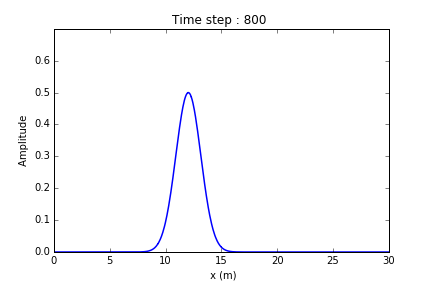

In [5]:
##------------------------------------------------------
# Initialize solution vectors
u = np.zeros(((N+1), ne))
uold = u
unew = u

x0 = 10 #center of the impulse
uold = 0.5 * np.exp(-0.4 * (x - x0) ** 2) #initial condition/impulse

#############
#choose between the different exercises
exercise = 1
#############

if exercise==2: #exercise 2, error between analytical and numerical solution
   ua = np.zeros(((N+1),ne))
   error = np.zeros((nt+1,(N+1)*ne)) #error array such that we can plot the error as a function of propagation distance
   ua = uold
    
elif exercise==4:# exercise 4: how discontinuous is the dg method?
    udiff = np.zeros((nt+1,ne))

    
############### Time extrapolation ####################################
#
# Choose between the Euler scheme and the second order Runge-Kutta scheme
method = 1 #Euler=0, RK=1
iplot = 10 # output interval

u = uold


#initialization for different plots, depending on the exercise
if exercise==2:
    uplot = np.reshape(u,((N+1)*ne),1) #u is reshaped to a vector in order to plot it against xg=vector with all the gll points
    uaplot = np.reshape(ua,((N+1)*ne),1)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    line, = ax1.plot(xg,uplot,color="blue",lw=1.5)
    line2, = ax1.plot(xg,uplot,color="red",lw=0.5)
    
    line3, = ax2.plot(error[0,:], color='green', lw=1.5)

    plt.ylim(0,0.7)
    plt.xlabel(' x (m)')
    plt.ylabel(' Amplitude ')
    fig.show();
       
    
elif exercise==1 or exercise==3:
    uplot = np.reshape(u,((N+1)*ne),1)
    fig = plt.figure()
    line, = plt.plot(xg,uplot,color="blue",lw=1.5)
    plt.ylim(0,0.7)
    plt.xlabel(' x (m)')
    plt.ylabel(' Amplitude ')
    fig.show();

alpha = 1 #you can choose alpha between [0,1] to get different flux concepts


####################
##-------Time loop

for it in range(1, nt+1):
    
    if method==0: #Euler scheme
        Flux=flux(alpha,u,N,ne,mu) #calculates the flux at the boundaries of an element
        
        # Extrapolation for every element
        for k in range(0,ne):
               unew[:,k] = dt* (np.dot(Minv, np.dot(Ke, u[:,k]) - Flux[:,k])) + u[:,k]
        u = unew

    
    else: #RK scheme
            Flux = flux(alpha,u,N,ne,mu) #calculates the flux at the boundaries of an element,
            k1 = np.dot(Minv, np.dot(Ke, u) - Flux)
            Flux = flux(alpha, u + dt * k1, N, ne, mu) #for a second order scheme this needs to be done twice in every iteration
            k2 = np.dot(Minv, np.dot(Ke, u+dt*k1)-Flux)
            u = u + 0.5 * dt * (k1 + k2)
    
##--Plotting section--###

    if not it % iplot:
        if exercise==2: #plot that compares the analytical and numerical solution, calculates the error
            uplot = np.reshape(u,((N+1) * ne),1)

            ua = 0.5*np.exp(-0.4*(x - (x0 + it * dt * mu)) ** 2)#analytical solution of the advection equation
            uaplot = np.reshape(ua,((N+1) * ne),1)
        
            line.set_ydata(uplot)
            line2.set_ydata(uaplot)
            error[it,:] = np.abs(uplot - uaplot)
            #maxerror=np.max(np.abs(uplot-uaplot))
            #error[it,:]=np.linalg.norm(uplot-uaplot) #2Norm

            ax1.set_title('Time step : %g ' %it)
            ax1.set_ylim([0.,0.7])
            fig.canvas.draw()
        
            lyaxis = np.max(np.abs(error)) #length of y-axis
            ax2.set_ylim([0,lyaxis])
    
            line3.set_ydata(error[it,:])
            distance = it * dt * mu
            ax2.set_title('Error (numerical-analytical) solution')

        
        elif exercise==4: #calculate the differences at the boundary points between two elements in every time step
            udiff[it,0:ne-1] = np.abs(u[0,1:ne] - u[N,0:ne-1])
        
        
        else: #plots only the solution u, for exercises 1,3
            uplot=np.reshape(u,((N+1)*ne),1)
            line.set_ydata(uplot)
            plt.title('Time step : %g ' %it)
            fig.canvas.draw()
        
### end of time loop        
####################


## Exercise 4: visualize the difference at the boundaries of an element at a given iteration step it
if exercise==4:
    itplot = input('Give a iteration step between 1 and %g: ' %nt)

    fig2=plt.figure()
    line4 = plt.plot(udiff[itplot,:], color='green', marker='o',label='grid points')    
    #ax = plt.axes()    

    
    fig2.show()
    lyaxis=np.max(udiff[itplot,:])
    plt.ylim(0,lyaxis)

    plt.title('Difference at the boundaries at iteration step %g' %itplot)
    plt.legend(loc=2)
    fig2.canvas.draw()
